In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15,10)
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Paired')

from arch.bootstrap import StationaryBootstrap
from scipy import stats
from scipy import interpolate
import datetime as dtm
from pandas.tseries.offsets import *

import crypto_pull as cp
from Backtester.OLS import OLS
from Backtester.SignalLibrary import Signals as sl
from Backtester import AssetAllocationToolbox as aat
from Portfolio import PortHelper as ph

import DatastreamPy as DSWS
ds = DSWS.Datastream(username="ZONT033", password="MOTOR506")

from DFA import DynamicFactorAnalysis as dfa
from DFA import DFAHelper as dfah

import numba as nb
from numba import jit
from scipy.optimize import basinhopping

from sklearn.linear_model import RidgeClassifier, Ridge
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\swagger_spec_validator\validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


In [3]:
def get_sigmoid_size(z, z_thresh=2, ls=True):
    pdf_signal = 1/(1 + np.exp(-z))
    pdf_thresh = 1/(1 + np.exp(-z_thresh))
    
    long_out_size = np.minimum(np.maximum(pdf_signal, 1-pdf_thresh), pdf_thresh)
    if ls: return 2*long_out_size - 1
    else: return long_out_size
    

def get_signal_weights(lkbks, halflife=6): 
    weights = 2**(-(np.array(lkbks)*(12/252))/halflife)
    return weights/weights.sum()

def get_stationary_block_samples(data, m, t, M):
    
    accept = 1/m
    len_data = len(data)
    sample_ix = np.random.randint(len_data)
    sample = np.zeros((t, M)).astype(int)
    for sim in range(M):
        for ix in range(t):
            if np.random.uniform() > accept:
                sample_ix = sample_ix + 1
                if sample_ix > len_data-1:
                    sample_ix = 0
            else:
                sample_ix = np.random.randint(len_data)
            sample[ix, sim] = sample_ix
    return sample

def get_strat_rets(df, vol_tgt=0.30):

    vols = (df.ewm(span=126, min_periods=21).std()*np.sqrt(252)).dropna()
    position_size = (((df+1).cumprod().to_frame().apply(get_bo_sig)+1)/2).multiply((vol_tgt/vols), axis=0)
    return position_size.shift(1).multiply(df.squeeze(), axis=0)[df.name]

def get_stats(x, tau):
    
    curve = (1+x).dropna().cumprod()
    geo_ret = curve.iloc[-1]**(tau/len(x))-1
    return pd.Series(
        [
            x.mean()*tau, geo_ret,
            x.std()*np.sqrt(tau), 
            x.mean()*np.sqrt(tau)/x.std(),
            x.mean()*np.sqrt(len(x.dropna()))/x.std(), 
            geo_ret/(x.std()*np.sqrt(tau)),
            (curve/curve.cummax()-1).abs().max(),
            (x.mean()*tau)/np.sqrt(((curve.subtract(curve.cummax())).\
                                    divide(curve.cummax())**2).mean()),
            (x.mean()*tau)/(curve/curve.cummax()-1).abs().max(),
            x.skew(), x.kurtosis()
        ], 
        index = ['Arith. Mean', 'Compound Mean', 'Volatility',
                 'SR', 't-Stat', 'Geo SR', 
                 'Max DD', 'Ulcer', 'Calmar',
                 'Skewness', 'Kurtosis']
        )

def get_ramom_cta(df, 
                  ls=False,
                  tsmom_lkbks = [21, 63, 252],
                  halflife=6,
                 ret_size=True):
    
    ra_mom = pd.concat({lkbk: df.pct_change(lkbk).\
                        divide(df.pct_change().rolling(lkbk).std()*np.sqrt(lkbk)) for lkbk in tsmom_lkbks}, axis=1)
    ra_mom = ra_mom.divide(ra_mom.ewm(span=252, min_periods=21).std())
    
    sig_w = get_signal_weights(tsmom_lkbks, halflife)
#     cta_sig = ra_mom.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    if ret_size:
        cta_sig = ra_mom.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    else: cta_sig = ra_mom.dot(sig_w)
    return cta_sig

    return cta_sig

def get_emac_cta(df,
                 ls=False,
                 lkbks=[[5, 20], [10, 40], [20, 80]],
                 weight_factors=[20, 40, 80], 
                 halflife=6,
                 ret_size=True):
    
    sig_w = get_signal_weights(weight_factors, halflife)
    emac_z_df = pd.concat(
                {
                    'emac_' + str(lkbk[0]) + '_' + str(lkbk[1]):
                    
                    (df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[0]))).mean().\
                            subtract(df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[1]))).mean())).divide(
                            df.ewm(halflife=int(np.log(0.5)/np.log(1-1/lkbk[1]))).std()
                    )
                    for lkbk in lkbks
                }, axis=1)
    cta_sig = emac_z_df.divide(emac_z_df.ewm(span=252, min_periods=21).std())
    if ret_size:
        cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    else: cta_sig = cta_sig.dot(sig_w)
    return cta_sig
    
def get_emabo_cta(df, 
                  ls=False,
                  ema_lkbks=[21, 63, 252], 
                  halflife=6,
                  ret_size=True):
    
    sig_w = get_signal_weights(ema_lkbks, halflife)
    breakout_z = pd.concat({lkbk: (df - df.ewm(span=lkbk, min_periods=21).mean().shift(1)).\
                                      divide(df.ewm(span=lkbk, min_periods=21).std().shift(1))
                                  for lkbk in ema_lkbks}, axis=1)
    cta_sig = breakout_z.divide(breakout_z.ewm(span=252, min_periods=21).std())
    if ret_size:
        cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    else: cta_sig = cta_sig.dot(sig_w)
    return cta_sig

def get_max_breakout_cta(df,
                         ls=False,
                         max_lkbks = [21, 63, 252],
                         halflife=6,
                         ret_size=True):

    sig_w = get_signal_weights(max_lkbks, halflife)
    max_breakout_sig = pd.concat({lkbk: (df - df.rolling(lkbk).max().shift(1)).\
                                  divide(df.ewm(span=lkbk, min_periods=21).std().shift(1))
                                 for lkbk in max_lkbks}, axis=1)
    cta_sig = max_breakout_sig.divide(max_breakout_sig.ewm(span=252, min_periods=21).std())
    if ret_size:
        cta_sig = cta_sig.apply(lambda x: get_sigmoid_size(x, ls=ls)).dot(sig_w)
    else: cta_sig = cta_sig.dot(sig_w)
    return cta_sig

def get_agg_signals(df, ls=False):
    ramom_cta = df.to_frame(df.name).dropna(how='all').apply(get_ramom_cta, args=(ls,))
    emac_cta = df.to_frame(df.name).dropna(how='all').apply(get_emac_cta, args=(ls,))
    emabo_cta = df.to_frame(df.name).dropna(how='all').apply(get_emabo_cta, args=(ls,))
    return pd.concat([ramom_cta, emac_cta, emabo_cta], axis=1).median(axis=1)

def discretize_size(x, m=0.2):
    return np.round(x/m, 0)*m

def get_vol_breakouts(df, lkbks=[63, 189]):
    
    sig_w = get_signal_weights(lkbks, 6)
    breakout_z = pd.concat({
        lkbk: (df - df.ewm(span=lkbk, min_periods=21).mean().shift(1)).\
                        divide(df.ewm(span=lkbk, min_periods=21).std().shift(1))
                            for lkbk in lkbks}, axis=1).dot(sig_w)
#     breakout_z_smooth = breakout_z.divide(breakout_z.ewm(span=252, min_periods=21).std()).dot(sig_w)
    return breakout_z

def inverse_logit(x):
    return np.log(x/(1-x))

def logit_cdf(x):
    return 1/(1+np.exp(-x))


def get_ports(rb_opt_df, returns, assets):
    
    rb_opt_df.index.name = 'Date'
    returns.index.name = None
    perf_df = 1+returns.loc[rb_opt_df.index[0]:].dropna(how='all')
    df_dts = pd.DataFrame(perf_df.index, index=perf_df.index, columns=['Date'])
    df_to_fill = pd.merge_asof(rb_opt_df, df_dts, 
                               direction='nearest', on='Date', left_index=True)
    mv_df= df_dts.drop(columns=['Date']).merge(df_to_fill, how='left',
                                               left_index=True, right_index=True).fillna(perf_df)
    mv_df['Date'] = mv_df['Date'].fillna(method='ffill')
    mv_df[assets] = mv_df.groupby('Date')[assets].apply(lambda x: np.cumprod(x))
    mv_df['count'] = mv_df.groupby('Date').cumcount()
    ret_df = returns.loc[mv_df.index[1:], assets].copy()
    w_df = pd.DataFrame(index=mv_df.index, columns=assets)
    w_df[mv_df['count'] == 0] = mv_df.loc[mv_df['count'] == 0, assets].copy()
    w_df['ix'] = np.where(mv_df['count'] == 0, 1, 0)
    port_rets = pd.DataFrame(index=mv_df.index, columns=['mv_0', 'PORT'])
    port_rets['mv_0'] = 1.0
    dts = mv_df.index
    for ix in range(len(dts)-1):
        port_rets.loc[dts[ix+1],'PORT'] = (w_df.loc[dts[ix],assets]*ret_df.loc[dts[ix+1]]).sum()
        if w_df.loc[dts[ix+1],'ix'] == 0:
            port_rets.loc[dts[ix+1], 'mv_0'] = port_rets.loc[dts[ix],'mv_0']*(1+port_rets.loc[dts[ix+1],'PORT'])
            w_df.loc[dts[ix+1],assets] = mv_df.loc[dts[ix+1]][assets]/port_rets.loc[dts[ix+1], 'mv_0']
            
    return port_rets, w_df

In [4]:
comm_etf_tickers = ['UGL US Equity', 'USO US Equity', 'USL US Equity', 
                    'UNG US Equity', 'SOYB US Equity', 'JJC US Equity',
                    'TMF US Equity', 'TYD US Equity', 'UPRO US Equity', 'TQQQ US Equity']
comm_fut_tickers = ['GC1 A:03_0_R Comdty', 'CL1 A:03_0_R Comdty', 'CL12 A:03_0_R Comdty',
                    'NG1 A:03_0_R Comdty', 'S 1 A:03_0_R Comdty', 'HG1 A:03_0_R Comdty',
                    'US1 A:03_0_R Comdty', 'TY1 A:03_0_R Comdty', 'ES1 A:03_0_R Index', 'NQ1 A:03_0_R Index']
comm_ids = ['GC1', 'CL1', 'CL12', 'NG1', 'S 1', 'HG1', 'US1', 'TY1','ES1', 'NQ1']

rf_df = sl.signal_get_data('US0001M Index', 
                           fields='TOT_RETURN_INDEX_GROSS_DVDS',
                           startdate='20000101').pull()

comm_etf_df = sl.signal_get_data(comm_etf_tickers, 
                                fields='TOT_RETURN_INDEX_GROSS_DVDS',
                                startdate='20000101').pull()
comm_etf_df.columns = comm_ids
comm_etf_df[['US1', 'TY1']] = (comm_etf_df[['US1', 'TY1']].pct_change().\
                                subtract(rf_df.shift(1)/(25200), axis=0)+1).cumprod()

comm_fut_df = sl.signal_get_data(comm_fut_tickers, 
                                fields='PX_LAST',
                                startdate='19900101').pull()
comm_fut_df.columns = comm_ids
comm_fut_df['GC1'] = (1+(comm_fut_df['GC1'].pct_change()*2)).cumprod()
comm_fut_df['US1'] = (1+(comm_fut_df['US1'].pct_change()*3)).cumprod()
comm_fut_df['TY1'] = (1+(comm_fut_df['TY1'].pct_change()*3)).cumprod()
comm_fut_df['ES1'] = (1+(comm_fut_df['ES1'].pct_change()*3)).cumprod()
comm_fut_df['NQ1'] = (1+(comm_fut_df['NQ1'].pct_change()*3)).cumprod()

comm_etf_df = (comm_etf_df.pct_change().fillna(comm_fut_df.pct_change())+1).cumprod()
comm_etf_df = (pd.concat([comm_fut_df.pct_change().loc[:comm_etf_df.pct_change().index[0]], 
                         comm_etf_df.pct_change()], axis=0)+1).cumprod().dropna(how='all')

In [5]:
es_df = sl.signal_get_data('ES1 A:03_0_R Index', 
                           fields='PX_LAST',
                           startdate='20000101').pull()
es_df.columns = ['ES1']

etf_df = sl.signal_get_data(['VIXY US Equity', 'SVXY US Equity', 
                             'SHORTVOL Index', 'TMF US Equity',
                             'DLR CN Equity'], 
                            fields='TOT_RETURN_INDEX_GROSS_DVDS',
                            startdate='20000101').pull()
etf_df.columns = ['vixy', 'svxy', 'svol', 'tmf', 'dlr']

etf_df[['vixy', 'svxy', 'svol', 'tmf']] = (etf_df[['vixy', 'svxy', 'svol', 'tmf']].pct_change().\
                                subtract(rf_df.shift(1)/(25200), axis=0)+1).cumprod()

vix_cash_df = sl.signal_get_data(['SPX Index', 'VIX Index', 'VIX3M Index',
                                 'VIX6M Index', 'VIX1Y Index', 'VVIX Index'], 
                                fields='PX_LAST',
                                startdate='19900101').pull()
vix_cash_df.columns = ['spx','vix','vix3m', 'vix6m', 'vix1y', 'vvix']

vix_fut_df = sl.signal_get_data([
                                 'UX1 A:03_0_N Index', 'UX2 A:03_0_N Index', 
                                 'UX3 A:03_0_N Index', 'UX4 A:03_0_N Index',
                                 'UX5 A:03_0_N Index', 'UX6 A:03_0_N Index',
                                 'UX7 A:03_0_N Index', 'UX8 A:03_0_N Index', 
                                 'UX9 A:03_0_N Index'], 
                                fields='PX_LAST',
                                startdate='19900101').pull()
vix_fut_df.columns = ['ux1', 'ux2', 'ux3',
                     'ux4', 'ux5', 'ux6', 
                     'ux7', 'ux8', 'ux9']
vix_fut_df.fillna(method='ffill', inplace=True)

vix_rx_df = sl.signal_get_data('UX1 A:03_0_R Index', 
                               fields=['PX_LAST', 'PX_OPEN', 'PX_VOLUME'],
                               startdate='20000101').pull()
vix_rx_df.columns = ['ux_volume','ux_last', 'ux_open']
etf_df['vixy'] = (etf_df['vixy'].pct_change().fillna(vix_rx_df['ux_last'].pct_change())+1).cumprod()

vix_put_call_oi = sl.signal_get_data('.VIXPCOI U Index', 
                                     fields='PX_LAST',
                                     startdate='20000101').pull()

# comm_tickers = ['UGL US Equity', 'SLV US Equity', 'JJC US Equity', 'DBB US Equity',
#                 'USO US Equity', 'USL US Equity', 'UNG US Equity', 'UGA US Equity',
#                 'WEAT US Equity', 'JO US Equity', 'CORN US Equity', 'CANE US Equity']

# bond_tickers = ['TMF US Equity','TYD US Equity']

# comm_df = sl.signal_get_data(comm_tickers, 
#                              fields='TOT_RETURN_INDEX_GROSS_DVDS',
#                              startdate='20000101').pull()

# bond_df = sl.signal_get_data(bond_tickers, 
#                              fields='TOT_RETURN_INDEX_GROSS_DVDS',
#                              startdate='20000101').pull()

In [6]:
def get_vfts_slope(x, y=list(np.arange(0,10)/12)):
    nan_ix = np.isnan(x.values)
    return stats.linregress(np.array(y)[~nan_ix], x[~nan_ix])[0]

vix_fut_df['roll_yield'] = vix_fut_df['ux1'].divide(vix_cash_df['vix'])
vix_fut_df['slope_1_2'] = vix_fut_df['ux2'].divide(vix_fut_df['ux1'])
vix_fut_df['slope_1_3'] = vix_fut_df['ux3'].divide(vix_fut_df['ux1'])
vix_fut_df['slope_mid'] = vix_fut_df['ux7'].divide(vix_fut_df['ux4'])
vix_fut_df['slope_long'] = vix_fut_df['ux9'].divide(vix_fut_df['ux1'])

vix_fut_df['cash_slope_1_3'] = vix_cash_df['vix3m'].divide(vix_cash_df['vix'])
vix_fut_df['cash_slope_1_6'] = vix_cash_df['vix6m'].divide(vix_cash_df['vix'])
vix_fut_df['cash_slope_long'] = vix_cash_df['vix1y'].divide(vix_cash_df['vix'])
vix_fut_df['cash_slope_3_6'] = vix_cash_df['vix6m'].divide(vix_cash_df['vix3m'])

fut_ts_df = pd.concat([vix_cash_df['vix'], 
                       vix_fut_df[['ux1', 'ux2', 'ux3','ux4', 'ux5', 'ux6', 'ux7', 'ux8', 'ux9']]], axis=1)['2004-03-26':]
vix_fut_df['fts_slope'] = fut_ts_df.apply(np.log).apply(get_vfts_slope, axis=1)
vix_fut_df['cash_ts_slope'] = vix_cash_df[['vix','vix3m','vix6m','vix1y']].apply(np.log).\
                                apply(get_vfts_slope, args=([1/12, 3/12, 6/12, 1.0],),axis=1)

vix_fut_df['ts_slope_avg'] = pd.concat([vix_fut_df['fts_slope'], vix_fut_df['cash_ts_slope']], axis=1).mean(axis=1)


bo_ids = ['roll_yield','slope_1_2',
          'slope_1_3', 'slope_mid',
          'slope_long', 'cash_slope_1_3', 
          'cash_slope_3_6', 'cash_slope_long']

emabo_ids = ['emabo_' + idx for idx in bo_ids]
ratio_ids =  ['ratio_' + idx for idx in bo_ids]

vix_fut_df[emabo_ids] = vix_fut_df[bo_ids].apply(get_vol_breakouts)
vix_fut_df[ratio_ids[0]] =  ((vix_fut_df['roll_yield'] > 1) & (vix_fut_df['emabo_roll_yield'] > 0)).astype(int)
vix_fut_df[ratio_ids[1]] =  ((vix_fut_df['slope_1_2'] > 1) & (vix_fut_df['emabo_slope_1_2'] > 0)).astype(int)
vix_fut_df[ratio_ids[2]] = ((vix_fut_df['slope_1_3'] > 1) & (vix_fut_df['emabo_slope_1_3'] > 0)).astype(int)
vix_fut_df[ratio_ids[3]] =((vix_fut_df['slope_mid'] > 1) & (vix_fut_df['emabo_slope_mid'] > 0)).astype(int)
vix_fut_df[ratio_ids[4]] = ((vix_fut_df['slope_long'] > 1) & (vix_fut_df['emabo_slope_long'] > 0)).astype(int)
vix_fut_df[ratio_ids[5]] = ((vix_fut_df['cash_slope_1_3'] > 1) & (vix_fut_df['emabo_cash_slope_1_3'] > 0)).astype(int)
vix_fut_df[ratio_ids[6]] = ((vix_fut_df['cash_slope_3_6'] > 1) & (vix_fut_df['emabo_cash_slope_3_6'] > 0)).astype(int)
vix_fut_df[ratio_ids[7]] = ((vix_fut_df['cash_slope_long'] > 1) & (vix_fut_df['emabo_cash_slope_long'] > 0)).astype(int)

cta_size = pd.concat([get_agg_signals(es_df, True).to_frame('es1'), 
                      get_agg_signals(etf_df['svol'], True).to_frame('svol')], axis=1).mean(axis=1)

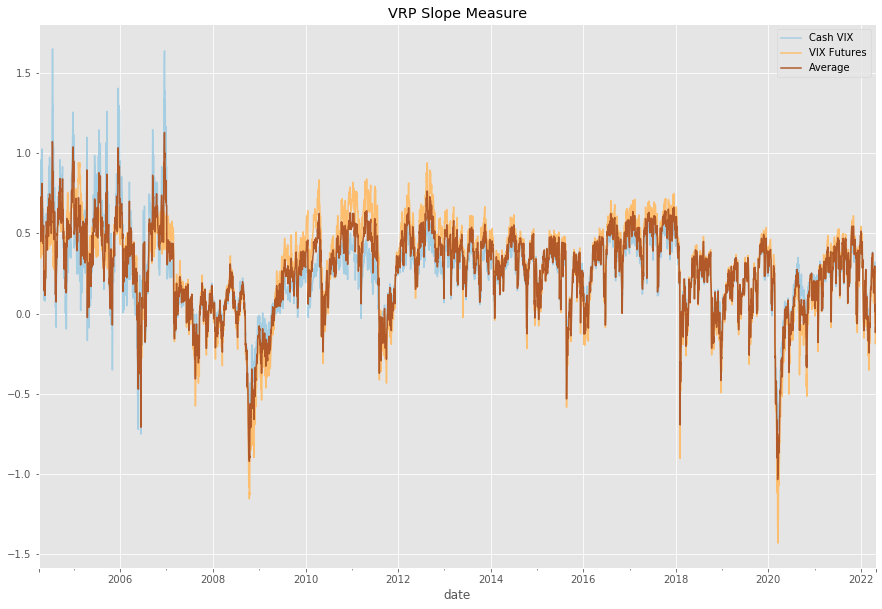

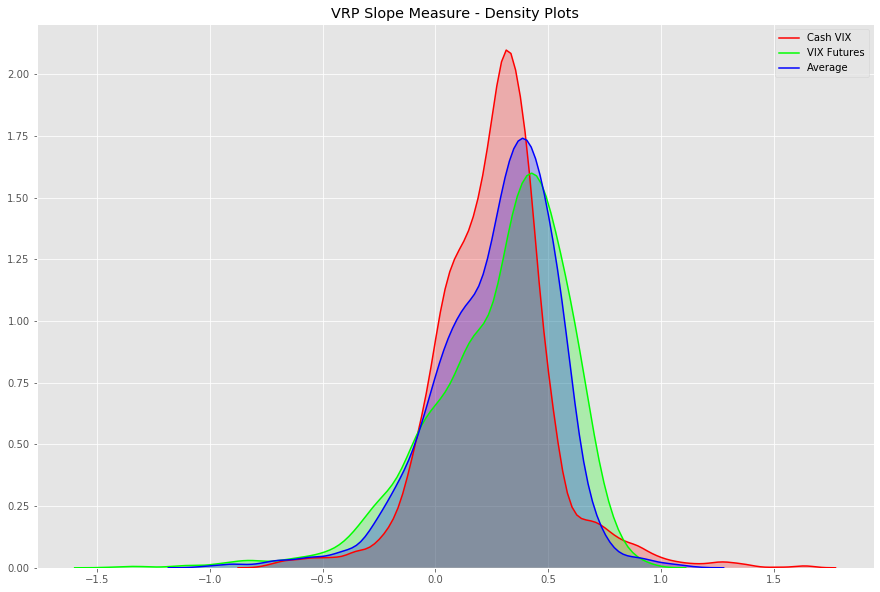

In [7]:
vix_fut_df[['cash_ts_slope', 'fts_slope', 'ts_slope_avg']].plot(cmap=cmap)
plt.title('VRP Slope Measure')
plt.legend(['Cash VIX', 'VIX Futures', 'Average'])

f1, ax1 = plt.subplots()
sns.kdeplot(vix_fut_df['cash_ts_slope'], shade=True, ax=ax1, color='red')
sns.kdeplot(vix_fut_df['fts_slope'], shade=True, ax=ax1, color='lime')
sns.kdeplot(vix_fut_df['ts_slope_avg'], shade=True, ax=ax1, color='blue')
plt.title('VRP Slope Measure - Density Plots')
plt.legend(['Cash VIX', 'VIX Futures', 'Average'])

In [8]:
vix_fut_df['cash_ts_slope_z'] = (vix_fut_df['cash_ts_slope'].subtract(vix_fut_df['cash_ts_slope'].ewm(span=63, min_periods=5).mean())).\
                                divide(vix_fut_df['cash_ts_slope'].ewm(span=63, min_periods=5).std())

vix_fut_df['fts_slope_z'] = (vix_fut_df['fts_slope'].subtract(vix_fut_df['fts_slope'].ewm(span=63, min_periods=5).mean())).\
                                divide(vix_fut_df['fts_slope'].ewm(span=63, min_periods=5).std())

vix_fut_df['ts_slope_avg_z'] = (vix_fut_df['ts_slope_avg'].subtract(vix_fut_df['ts_slope_avg'].ewm(span=63, min_periods=5).mean().shift(1))).\
                                                                    divide(vix_fut_df['ts_slope_avg'].ewm(span=63, min_periods=5).std().shift(1))

down_thresh = 1
up_thresh = 1

signal_df = pd.DataFrame(index=vix_fut_df.index)
signal_df['long_pos'] = (vix_fut_df['ts_slope_avg'] > 0) & (vix_fut_df['ts_slope_avg_z'] > 0)
signal_df['short_pos'] = (vix_fut_df['ts_slope_avg'] > 0) & (vix_fut_df['ts_slope_avg_z'] < 0)
signal_df['long_neg'] = (vix_fut_df['ts_slope_avg'] < 0) & (vix_fut_df['ts_slope_avg_z'] > -up_thresh)
signal_df['short_neg'] = (vix_fut_df['ts_slope_avg'] < 0) & (vix_fut_df['ts_slope_avg_z'] < -down_thresh)

signal_df['cash_ts_signal'] = np.nan
signal_df['cash_ts_signal'] = np.where(signal_df['long_pos'],
                                       1, signal_df['cash_ts_signal'])
signal_df['cash_ts_signal'] = np.where(signal_df['short_pos'],
                                       -1, signal_df['cash_ts_signal'])
signal_df['cash_ts_signal'] = np.where(signal_df['short_pos'].shift(1) & signal_df['short_neg'], 
                                       -1, signal_df['cash_ts_signal'])
signal_df['cash_ts_signal'] = np.where(signal_df['short_neg'].shift(1) & signal_df['long_neg'],
                                       1, signal_df['cash_ts_signal'])
signal_df['cash_ts_signal'].fillna(method='ffill', inplace=True)

In [9]:
model_data = pd.concat([signal_df['cash_ts_signal'],
                        vix_fut_df[[*emabo_ids, *ratio_ids]],
                        vix_put_call_oi.to_frame('vix_pc').apply(get_vol_breakouts).dropna(),
                        etf_df['svol'].pct_change()], axis=1).dropna(how='all').loc['2007-01-01':]
model_data['target'] = (model_data['svol'].apply(np.sign) == model_data['cash_ts_signal'].shift(1).apply(np.sign)).astype(int)
model_data.drop(columns='svol', inplace=True)
model_data.fillna(method='ffill', inplace=True)

In [10]:
hyper_params = {
    'alpha': 1/(2*np.logspace(-4, 2, 20))
}
    
cv_dict = {
    
    'n_splits': 4,
    'rs': 42,
    'scoring': 'neg_mean_squared_error',
    'n_jobs': 10
}

model_args = {
    'random_state': cv_dict['rs'],
}


start_ix = 252*2
tau = 1
oos = 21
y = model_data['target'].copy().iloc[:-tau]
X_df = model_data.drop(columns='target')
model = Ridge
pred_df = pd.DataFrame(index=y.iloc[start_ix:].index, columns=['probs'])
coef_df = pd.DataFrame(columns=X_df.columns)
hparams_dict = {}

for ix in list(range(start_ix, y.shape[0] - tau, oos)):
    
    X_train = X_df.shift(tau).iloc[:ix].dropna(how='all')
    X_train = X_train.fillna(X_train.mean())
    y_train = y.loc[X_train.index]
    
    y_train = y_train.apply(lambda x: np.maximum(x, 1e-9)).\
                        apply(lambda x: np.minimum(x, 1-1e-9)).apply(stats.norm.ppf)
    
    dt = X_train.iloc[:ix].index[-1].strftime('%Y-%m-%d')
    print('Currently running {}'.format(dt))
    
    y_test = y.iloc[ix:ix + oos]
    X_test = X_df.loc[y_test.index, X_train.columns].dropna(axis=1, how='any')
    
    X_scaler = MinMaxScaler((-1,1)).fit(X_train)    
    X_train_scaled = X_scaler.transform(X_train)

    cross_val = TimeSeriesSplit(n_splits=cv_dict['n_splits'])
    hyper_search = GridSearchCV(estimator=model(**model_args),
                                param_grid=hyper_params,
                                scoring=cv_dict['scoring'],
                                cv=cross_val,
                                n_jobs=cv_dict['n_jobs'])

    hyper_opt = hyper_search.fit(X_train_scaled, y_train)
    hparams_dict[dt] = hyper_opt.best_params_
    
    model_opt = model(**hparams_dict[dt], **model_args).fit(X_train_scaled, y_train)    
    y_preds = model_opt.predict(np.clip(X_scaler.transform(X_test), -1,1))
    pred_df.loc[y_test.index, 'probs'] = stats.norm.cdf(y_preds)
    coef_df.loc[dt] = model_opt.coef_
    
    try:
        auc = metrics.roc_auc_score(y[pred_df.dropna().index], pred_df.dropna(), average='weighted')
        print('Test AUC: {:.2%}'.format(auc))
    except: 
        pass 

Currently running 2008-12-04
Test AUC: 54.81%
Currently running 2009-01-02
Test AUC: 45.08%
Currently running 2009-02-02
Test AUC: 46.77%
Currently running 2009-03-03
Test AUC: 42.84%
Currently running 2009-04-01
Test AUC: 49.74%
Currently running 2009-04-30
Test AUC: 51.77%
Currently running 2009-05-29
Test AUC: 54.35%
Currently running 2009-06-29
Test AUC: 55.43%
Currently running 2009-07-28
Test AUC: 54.76%
Currently running 2009-08-26
Test AUC: 52.51%
Currently running 2009-09-24
Test AUC: 53.01%
Currently running 2009-10-23
Test AUC: 52.87%
Currently running 2009-11-23
Test AUC: 54.73%
Currently running 2009-12-22
Test AUC: 54.68%
Currently running 2010-01-20
Test AUC: 54.40%
Currently running 2010-02-18
Test AUC: 55.20%
Currently running 2010-03-19
Test AUC: 55.33%
Currently running 2010-04-19
Test AUC: 54.19%
Currently running 2010-05-18
Test AUC: 54.77%
Currently running 2010-06-16
Test AUC: 54.42%
Currently running 2010-07-15
Test AUC: 53.95%
Currently running 2010-08-13
Test 

Text(0.5, 1.0, 'Vol Meta Model - Ridge Coefficients')

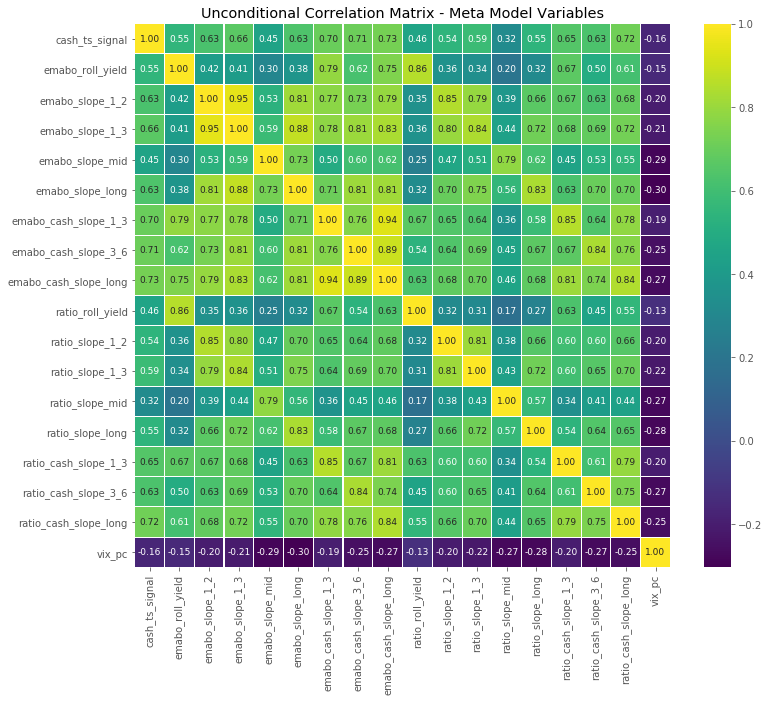

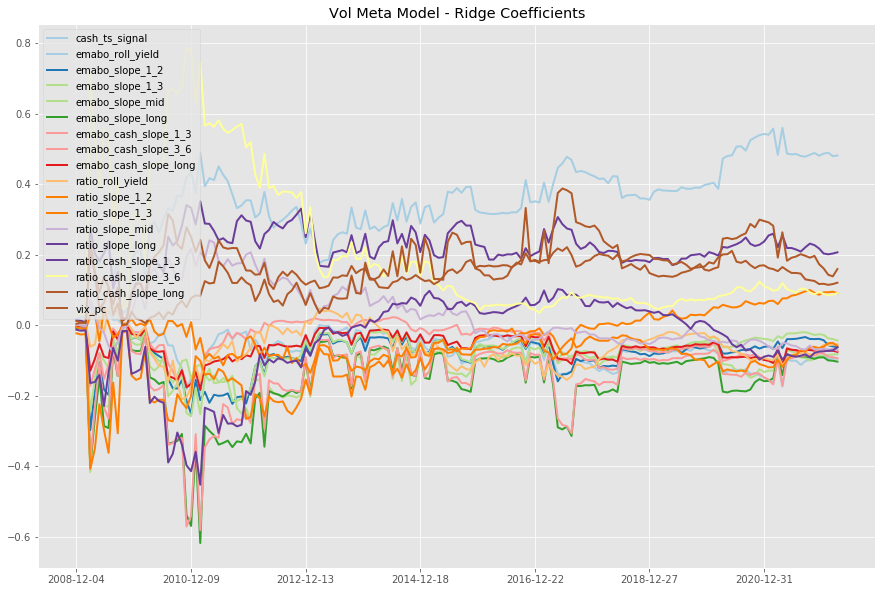

In [73]:
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(model_data.loc[:,:'vix_pc'].corr('spearman'), ax=ax,
            cmap='viridis', annot=True, fmt='0.2f', annot_kws={"size": 9},
            linewidths=0.1, linecolor='white')
plt.title('Unconditional Correlation Matrix - Meta Model Variables')

coef_df.dropna(how='all').fillna(method='ffill').plot(cmap=cmap, lw=2)
plt.title('Vol Meta Model - Ridge Coefficients')

In [132]:
vol_tgt = (0.15/np.sqrt(252))
assets = ['GC1', 'CL1', 'CL12', 'NG1', 'S 1', 'HG1', 'US1', 'TY1']

cta_df = comm_etf_df[assets]
corr_df = cta_df.apply(np.log).diff().ewm(halflife=int(252), min_periods=21).corr().dropna()
vol_df = cta_df.apply(np.log).diff().ewm(halflife=int(63), min_periods=21).std().dropna()
cov_df = corr_df.groupby(level=0, axis=0).apply(
                lambda x: pd.DataFrame(dfah.corr2cov(vol_df.loc[x.name].values, x.values),
                                       index=x.columns,
                                       columns=x.columns))

signals_df = cta_df.apply(get_agg_signals, args=(True,))

,comm_cta
Arith. Mean,0.116139
Compound Mean,0.106219
Volatility,0.163312
SR,0.711146
t-Stat,4.076368
Geo SR,0.650404
Max DD,0.252341
Ulcer,1.176128
Calmar,0.460246
Skewness,0.074405


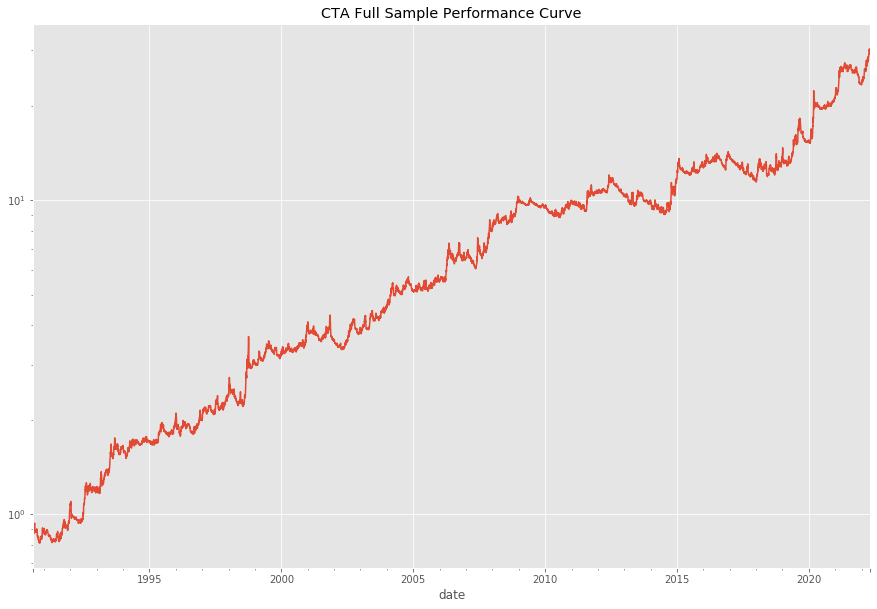

In [133]:
quantum = np.hstack([
    (np.repeat((1/(vol_df.shape[1]-2)), vol_df.shape[1]-2)*0.60),
     np.repeat(1/2, 2)*0.40])

cta_position_size_unlev_df = (signals_df.multiply((vol_tgt/vol_df)**2))*quantum
inst_vol = cta_position_size_unlev_df.dropna().apply(
    lambda x: np.sqrt(x.dot(cov_df.loc[x.name].values).dot(x.T)),
    axis=1)

cta_position_size_df = cta_position_size_unlev_df.multiply(
                        vol_tgt/(inst_vol**2).expanding(min_periods=63).mean().apply(np.sqrt),
                        axis=0).shift(1)
comm_cta = cta_position_size_df.shift(1).multiply(cta_df.pct_change(), axis=0).sum(axis=1, skipna=False)

((comm_cta.dropna()+1).cumprod()).plot(logy=True)
plt.title('CTA Full Sample Performance Curve')
comm_cta.to_frame('comm_cta').apply(get_stats, args=(252,))

Text(0.5, 1.0, 'CTA Position Size - Commodities')

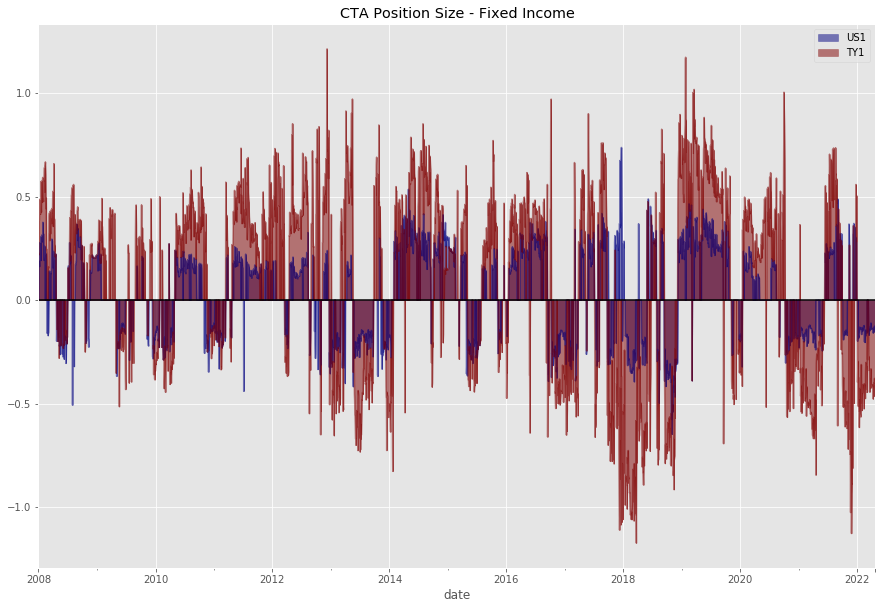

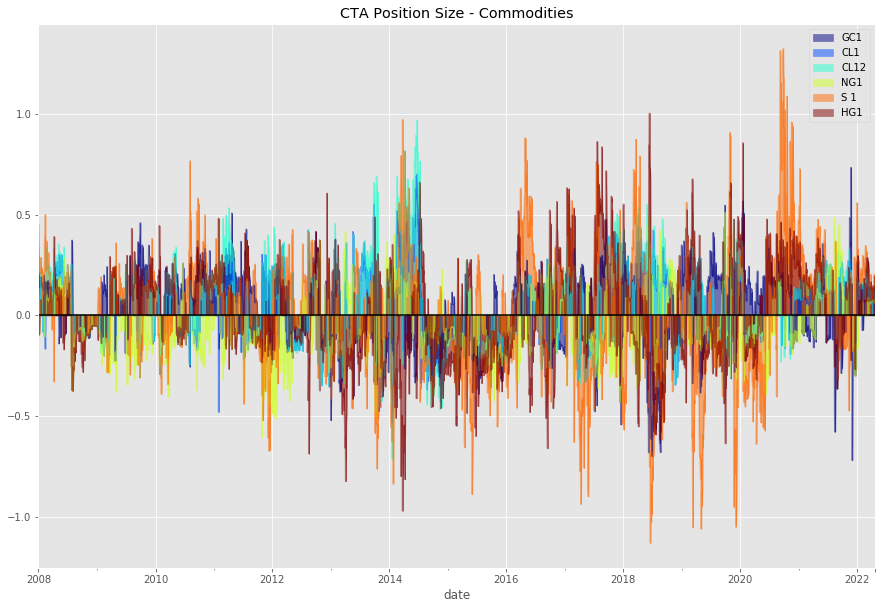

In [76]:
cta_position_size_df[assets[-2:]].loc['2008':].plot.area(stacked=False, cmap='jet')
plt.axhline(0,color='black')
plt.title('CTA Position Size - Fixed Income')

cta_position_size_df[assets[:-2]].loc['2008':].plot.area(stacked=False, cmap='jet')
plt.axhline(0,color='black')
plt.title('CTA Position Size - Commodities')

In [134]:
vol_tgt = 0.20
lag = 1

def get_tactical_weights(quantum, cta_comp):
    model_weights = quantum.copy()
    model_weights.columns = ['SVOL', 'VIXY', 'CTA']
    model_weights[assets] = cta_comp.shift(1).\
                            multiply(model_weights['CTA'], axis=0)
    return model_weights[[*['SVOL', 'VIXY'], *assets]]

svol_risk = etf_df['svol'].pct_change().ewm(com=63, min_periods=21).std()*np.sqrt(252)
vixy_risk = etf_df['vixy'].pct_change().ewm(com=63, min_periods=21).std()*np.sqrt(252)
vol_sig = (signal_df['cash_ts_signal']).apply(lambda x:(1+x)/2)
vol_sig_meta = (signal_df['cash_ts_signal']).multiply((pred_df['probs']>0.40).astype(int)).apply(lambda x:(1+x)/2)

position_size_df = pd.DataFrame()
position_size_df['svol_position_size'] = vol_sig.multiply(vol_tgt/svol_risk).apply(discretize_size)
position_size_df['vixy_position_size'] = (1-vol_sig).multiply(vol_tgt/vixy_risk).apply(discretize_size)
position_size_df['svol_position_size_meta'] = vol_sig_meta.multiply(vol_tgt/svol_risk)
position_size_df['vixy_position_size_meta'] = (1-vol_sig_meta).multiply(vol_tgt/vixy_risk)
position_size_df['volsize_delta_meta']  = position_size_df['svol_position_size_meta'].\
                                            subtract(position_size_df['vixy_position_size_meta']).apply(np.round, args=(2, ))
position_size_df['volsize_delta']  = position_size_df['svol_position_size'].\
                                            subtract(position_size_df['vixy_position_size']).apply(np.round, args=(2, ))

delta_reg = (position_size_df['volsize_delta'] > -1e-2) & (position_size_df['volsize_delta'] < 1e-2)
delta_meta = (position_size_df['volsize_delta_meta'] > -1e-2) & (position_size_df['volsize_delta_meta'] < 1e-2)

position_size_df.loc[delta_reg, ['svol_position_size', 'vixy_position_size']] = 0.0
position_size_df.loc[delta_meta, ['svol_position_size_meta', 'vixy_position_size_meta']] = 0.0
position_size_df['cta_weight'] = 1 - position_size_df[['svol_position_size', 'vixy_position_size']].sum(axis=1)
position_size_df['cta_weight_meta'] = 1 - position_size_df[['svol_position_size_meta', 'vixy_position_size_meta']].sum(axis=1)
position_size_df[assets] = cta_position_size_df.multiply(position_size_df['cta_weight_meta'], axis=0)


vol_strat = (position_size_df['svol_position_size'].shift(lag).multiply(etf_df['svol'].pct_change())).\
            add(position_size_df['vixy_position_size'].shift(lag).multiply(etf_df['vixy'].pct_change())).to_frame('vol_strat')

vol_strat['vol_strat_meta'] = (position_size_df['svol_position_size_meta'].shift(lag).multiply(etf_df['svol'].pct_change())).\
            add(position_size_df['vixy_position_size_meta'].shift(lag).multiply(etf_df['vixy'].pct_change())).to_frame('vol_strat_meta')

vol_strat['bonds_comm_cta'] = comm_cta.copy()

normal_weights = get_tactical_weights(position_size_df[['svol_position_size',
                                                      'vixy_position_size', 
                                                      'cta_weight']].dropna(),
                                    cta_position_size_df)

weight_constr_normal = (normal_weights.sum(axis=1)>1) | (normal_weights.sum(axis=1)<-1)
normal_weights.loc[weight_constr_normal] =  normal_weights.loc[weight_constr_normal].\
                                        apply(lambda x: 1*x/np.nansum(np.abs(x)), axis=1)

meta_weights = get_tactical_weights(position_size_df[['svol_position_size_meta',
                                                      'vixy_position_size_meta', 
                                                      'cta_weight_meta']].dropna(),
                                    cta_position_size_df).apply(np.round, args=(2,))

weight_constr_meta = (meta_weights.sum(axis=1)>1) | (meta_weights.sum(axis=1)<-1)
meta_weights.loc[weight_constr_meta] =  meta_weights.loc[weight_constr_meta].\
                                        apply(lambda x: 1*x/np.nansum(np.abs(x)), axis=1)
asset_rets = pd.concat([etf_df['svol'].pct_change().to_frame('SVOL'),
                        etf_df['vixy'].pct_change().to_frame('VIXY'),
                        cta_df.pct_change()], axis=1).dropna()

vol_strat['tactical_strat'] = normal_weights.shift(lag).multiply(asset_rets, axis=1).sum(axis=1, skipna=False)
vol_strat['tactical_strat_meta'] = meta_weights.shift(lag).multiply(asset_rets, axis=1).sum(axis=1, skipna=False)
vol_strat['ES1'] = es_df.pct_change()
vol_strat['TY1'] = comm_etf_df['TY1'].pct_change()
vol_strat['SVOL'] = etf_df['svol'].pct_change()

,VRP,VRP Meta,CTA,VRP+CTA,VRP+CTA Meta,ES1,TY1,SVOL
Arith. Mean,0.157616,0.159258,0.091047,0.215593,0.226609,0.139130,0.060158,0.477674
Compound Mean,0.146294,0.158261,0.081260,0.205243,0.229791,0.131149,0.038840,0.272806
Volatility,0.205935,0.157064,0.160791,0.241406,0.199107,0.177916,0.210170,0.670046
SR,0.765368,1.013969,0.566245,0.893070,1.138125,0.782000,0.286235,0.712896
t-Stat,2.849098,3.774518,2.107858,3.324470,4.236691,2.911009,1.065515,2.653770
Geo SR,0.710389,1.007625,0.505379,0.850196,1.154105,0.737141,0.184800,0.407145
Max DD,0.282672,0.262550,0.252341,0.398916,0.308538,0.341751,0.423305,0.923034
Ulcer,1.526651,1.900359,0.851480,1.581359,2.314802,2.524566,0.396163,1.105047
Calmar,0.557595,0.606580,0.360809,0.540447,0.734461,0.407109,0.142115,0.517504
Skewness,0.869274,0.485916,0.240641,1.021451,0.879629,-0.327420,0.257152,-1.538585


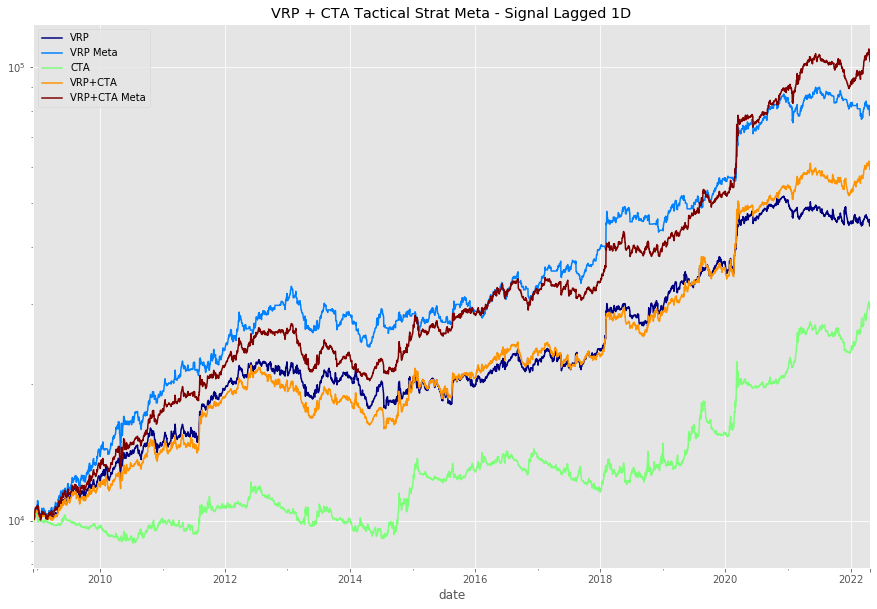

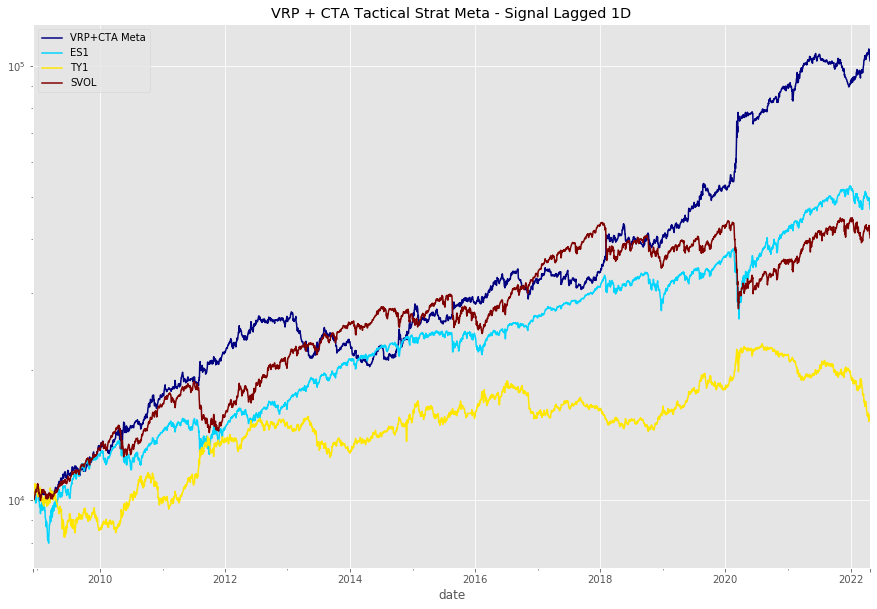

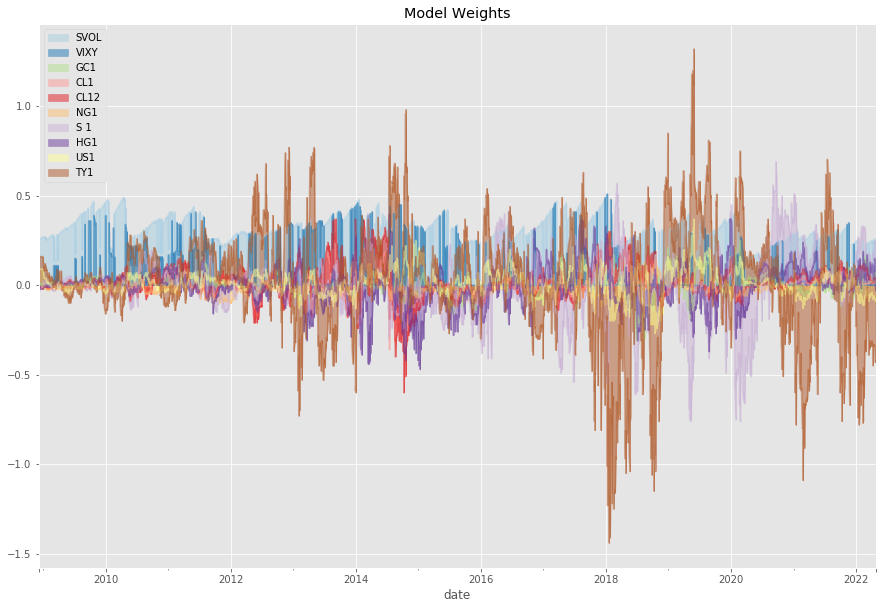

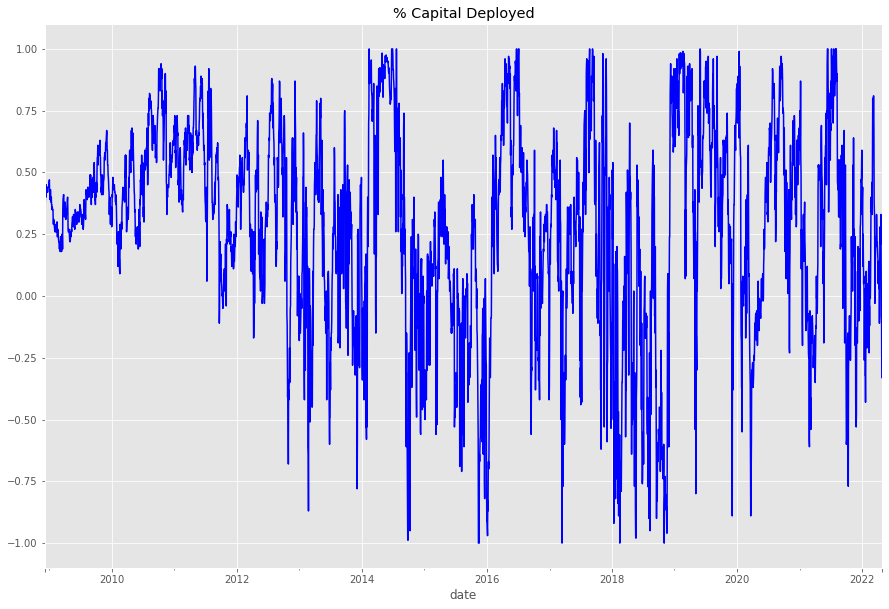

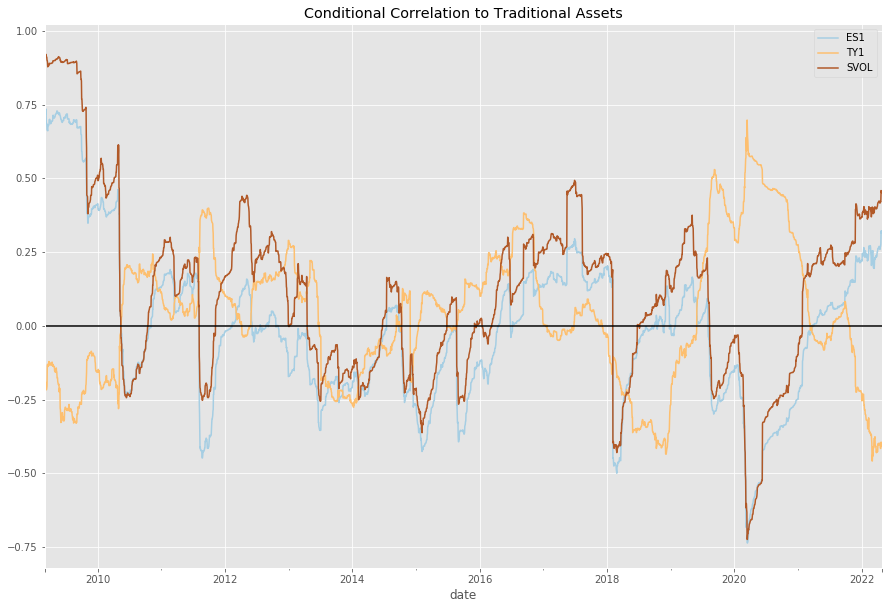

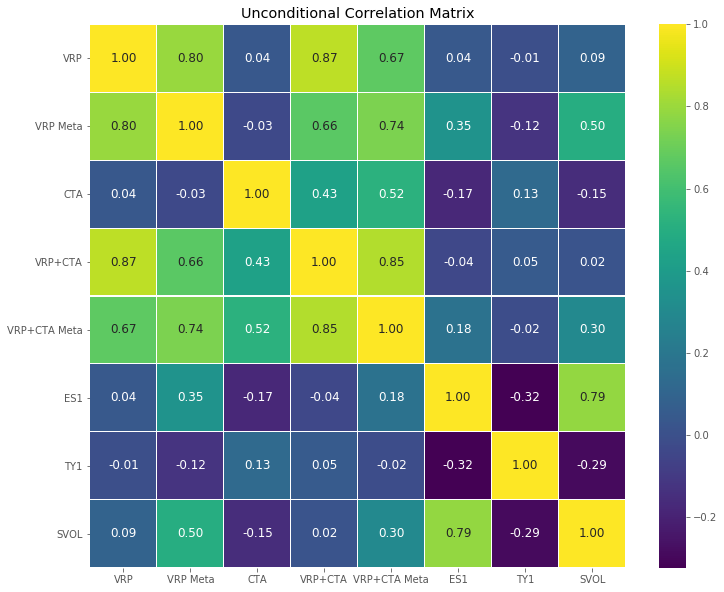

In [135]:
vol_strat.columns = ['VRP', 'VRP Meta', 'CTA', 'VRP+CTA', 'VRP+CTA Meta', 'ES1', 'TY1', 'SVOL']

((vol_strat[['VRP', 'VRP Meta', 'CTA', 'VRP+CTA', 'VRP+CTA Meta']].dropna().\
              apply(lambda x: x*(0.01)/x.std())+1).cumprod()*10000).plot(cmap='jet', logy=True)
plt.title('VRP + CTA Tactical Strat Meta - Signal Lagged {}D'.format(lag))

((vol_strat[['VRP+CTA Meta', 'ES1', 'TY1', 'SVOL']].dropna().\
              apply(lambda x: x*(0.01)/x.std())+1).cumprod()*10000).plot(cmap='jet', logy=True)
plt.title('VRP + CTA Tactical Strat Meta - Signal Lagged {}D'.format(lag))

meta_weights[[*['SVOL', 'VIXY'],*assets]].plot.area(stacked=False, cmap=cmap)
plt.title('Model Weights')

f, ax = plt.subplots()
meta_weights.sum(axis=1).plot(ax=ax, color='blue')
plt.title('% Capital Deployed')

vol_strat.ewm(span=252, min_periods=63).corr(vol_strat['VRP+CTA Meta'])[['ES1', 'TY1', 'SVOL']].dropna().plot(cmap=cmap)
plt.title('Conditional Correlation to Traditional Assets')
plt.axhline(0, color='black')
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(vol_strat.dropna().corr('spearman'), ax=ax,
            cmap='viridis', annot=True, fmt='0.2f', annot_kws={"size": 12},
            linewidths=0.1, linecolor='white')
plt.title('Unconditional Correlation Matrix')

vol_strat.dropna().apply(get_stats, args=(252,))

(0, 1)

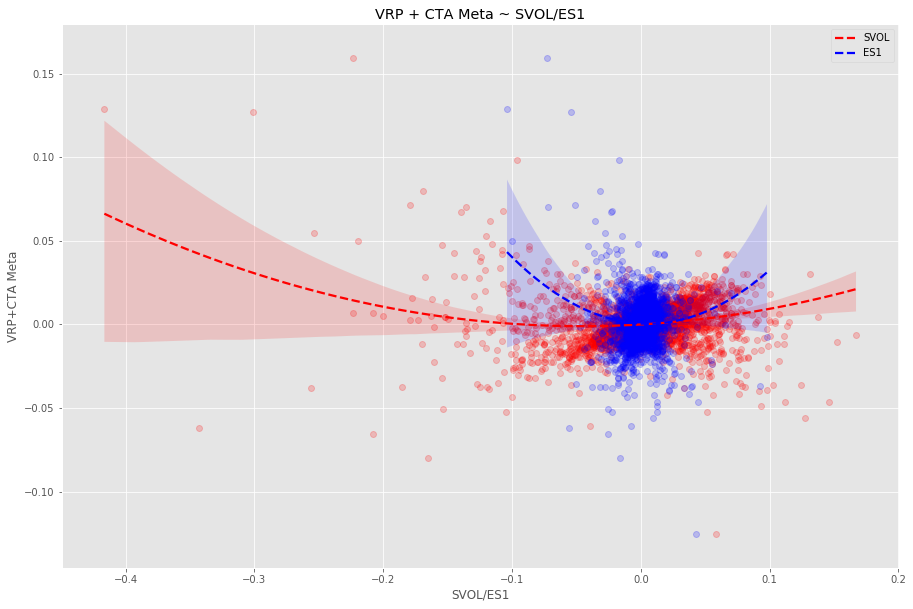

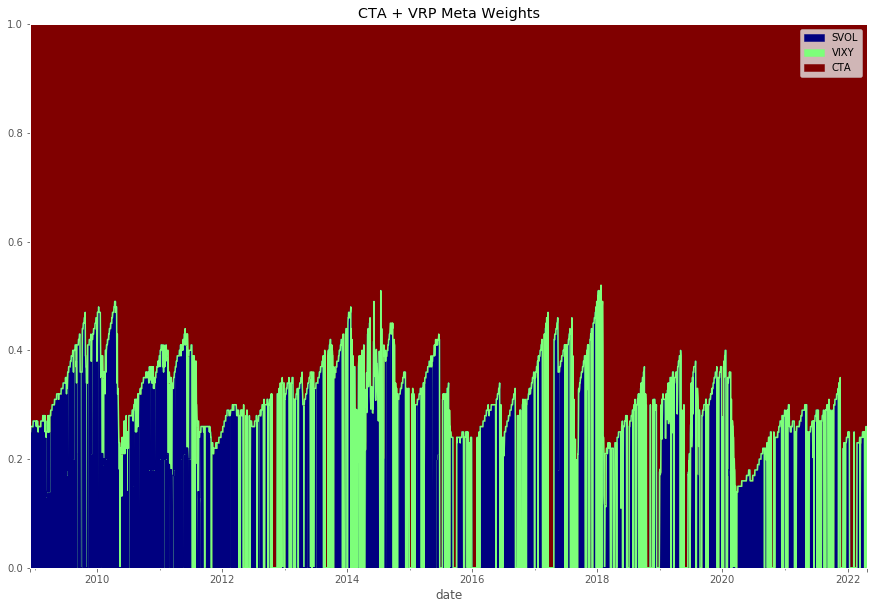

In [129]:
sns.regplot(x='SVOL',
            y='VRP+CTA Meta', 
            data=vol_strat.dropna(),
            order=2, scatter_kws={'alpha': 0.2},
            color='red',
            line_kws={'color':'red', 'linestyle':'--'})

sns.regplot(x='ES1',
            y='VRP+CTA Meta', 
            data=vol_strat.dropna(),
            order=2, scatter_kws={'alpha': 0.2},
            color='blue',
            line_kws={'color':'blue', 'linestyle':'--'})


plt.legend(['SVOL', 'ES1'])
plt.xlabel('SVOL/ES1')
plt.title('VRP + CTA Meta ~ SVOL/ES1')

weights = meta_weights[['SVOL','VIXY']].copy()
weights['CTA'] = 1-weights.sum(axis=1)
weights.plot.area(cmap='jet')
plt.title('CTA + VRP Meta Weights')
plt.ylim(0,1)

In [233]:
@jit(nopython=True)
def ou_spec(X_t, theta, mu):
    return np.multiply(theta , np.subtract(mu, X_t))

@jit(nopython=True)
def mu_spec(x_t):
    return np.mean(x_t)

@jit(nopython=True)
def gjrgarch_spec(omega, alpha, beta, gamma, e_t_1, sigma2_t_1):
    return omega + (alpha + gamma*(e_t_1>0))*e_t_1**2 + beta*sigma2_t_1

@jit(nopython=True)
def LogLikeSpec(e2_t_1, sigma2_t_1):
    z_t_1 = np.sqrt(e2_t_1 / sigma2_t_1)
#     if (z_t_1 > 20):
#         z_t_1 = 20
#     elif (z_t_1 < -20):
#         z_t_1 = -20
    return -0.5 * (np.log(sigma2_t_1) + z_t_1 ** 2)

@jit(nopython=True)
def gjrgarch_series(params, x_t, loglike=True):
    sigma_2 = [params[0]]
    ll = [LogLikeSpec(x_t[0] ** 2, sigma_2[0])]

    for ix in range(1, len(x_t)):
        sigma_2.append(gjrgarch_spec(params[1], params[2], params[3], 
                                     params[4], x_t[ix - 1], sigma_2[ix - 1]))
        ll.append(np.maximum(np.log(1e-300), LogLikeSpec(x_t[ix] ** 2, sigma_2[ix])))

    if loglike is True:
        return ll
    else:
        return sigma_2


def mu_gjrgarch_cost_fun(params, x_t):
    """
    :param params: Array with parameter estimates for NGARCH process
    :param x_t: Array containing the excess returns
    :return: Sum of log likelihoods
    """

    e_t = np.diff(np.log(x_t)) - mu_spec(np.diff(np.log(x_t)))
    return -(np.sum(gjrgarch_series(params, e_t)))

def ou_gjrgarch_cost_fun(params, x_t):
    """
    :param params: Array with parameter estimates for NGARCH process
    :param x_t: Array containing the excess returns
    :return: Sum of log likelihoods
    """

    e_t = np.diff(np.log(x_t)) - ou_spec(np.log(x_t)[1:], params[0], params[1])
    return -(np.sum(gjrgarch_series(params[2:], e_t)))

def get_ou_gjr_garch(X_t,params):
    
    x_t = X_t.values
    e_t = np.diff(np.log(x_t)) - ou_spec(np.log(x_t)[1:], params[0], params[1])
    var_t = gjrgarch_series(params[2:], e_t, loglike=False)
    return pd.Series(var_t, index=X_t.index[1:], name=X_t.name)

def get_mu_gjr_garch(X_t,params):
    
    x_t = X_t.values
    e_t = np.diff(np.log(x_t)) - mu_spec(np.diff(np.log(x_t)))
    var_t = gjrgarch_series(params, e_t, loglike=False)
    return pd.Series(var_t, index=X_t.index[1:], name=X_t.name)

@jit(nopython=True)
def get_ou_gjr_garch_forecast(vol, params, h=20):
    var = vol**2
    var_h = [var]
    for t in range(h):
        var_h.append(params[0] + (params[1] + params[3]/2 + params[2])*var_h[-1])
    return np.sum(np.array(var_h))

x_t = vix_cash_df['vix'].loc[:'2005/12'].values
mu_params = np.array([1e-6, 0.001])
mu_bnds = ((1e-12, 1), (1e-12, 1),)
# mu_params = np.array([])
# mu_bnds = ()

x0 = np.hstack([mu_params, np.array([0.012, 0.001, 0.01, 0.85, 0.20])])
bnds = mu_bnds + ((1e-12, 1.0), (1e-12, 1.0), 
                  (1e-12, 1.0), (1e-12, 1.0),
                  (-0.9999, 0.9999))
cons = {'type': 'ineq', 'fun': lambda x: -(x0[-3] + x0[-2] + x0[-1]/2) + 1}
minimizer_kwargs = {'method': 'SLSQP', 'args': (x_t),
                    'bounds': bnds, 'constraints': cons,
                    'options': {'maxiter': 1e5, 'ftol': 1e-12}}

basinhopper = basinhopping(ou_gjrgarch_cost_fun, 
                           x0,
                           stepsize=0.50, 
                           T=1,
                           niter=100, 
                           seed=42,
                           minimizer_kwargs=minimizer_kwargs)
params = basinhopper.x

In [234]:
basinhopper

                        fun: -10132.039873142685
 lowest_optimization_result:      fun: -10132.039873142685
     jac: array([ 9.35954480e+03, -2.21643066e+00,  1.29864502e+01,  1.06668384e+05,
        4.02567017e+02,  2.55505005e+02,  1.52383911e+02])
 message: 'Optimization terminated successfully.'
    nfev: 241
     nit: 27
    njev: 23
  status: 0
 success: True
       x: array([6.47427183e-04, 7.39690815e-01, 1.00981868e-01, 7.45183798e-04,
       1.06780958e-01, 6.32357069e-01, 7.85130009e-02])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 62
                       nfev: 5111
                        nit: 100
                       njev: 505
                          x: array([6.47427183e-04, 7.39690815e-01, 1.00981868e-01, 7.45183798e-04,
       1.06780958e-01, 6.32357069e-01, 7.85130009e-02])

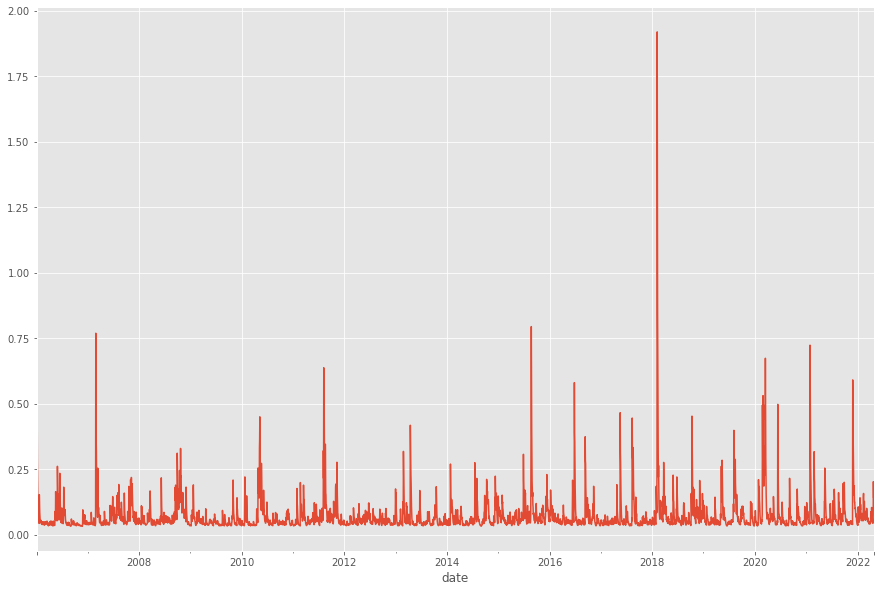

In [236]:
(get_ou_gjr_garch(vix_cash_df['vix'].loc['2006/01':], params)*15.9).plot()

In [235]:
(get_ou_gjr_garch(vix_cash_df['vix'].loc['2006/01':], params)*15.9).loc['2018/01':'2018/03'].head(60)

date
2018-01-01    0.055266
2018-01-02    0.046800
2018-01-03    0.066387
2018-01-04    0.060916
2018-01-05    0.050586
2018-01-08    0.043840
2018-01-09    0.042779
2018-01-10    0.048871
2018-01-11    0.043825
2018-01-12    0.039710
2018-01-15    0.039431
2018-01-16    0.036786
2018-01-17    0.091884
2018-01-18    0.071422
2018-01-19    0.059135
2018-01-22    0.060065
2018-01-23    0.050541
2018-01-24    0.043970
2018-01-25    0.043037
2018-01-26    0.039397
2018-01-29    0.039910
2018-01-30    0.184443
2018-01-31    0.141967
2018-02-01    0.114501
2018-02-02    0.084281
2018-02-05    0.252515
2018-02-06    1.918811
2018-02-07    1.305374
2018-02-08    0.847207
2018-02-09    0.653528
2018-02-12    0.458050
2018-02-13    0.327926
2018-02-14    0.220169
2018-02-15    0.264270
2018-02-16    0.179010
2018-02-19    0.126060
2018-02-20    0.091569
2018-02-21    0.079804
2018-02-22    0.063560
2018-02-23    0.059374
2018-02-26    0.076136
2018-02-27    0.062909
2018-02-28    0.130896
2018-0

In [223]:
basinhopper

                        fun: -10162.529542543549
 lowest_optimization_result:      fun: -10162.529542543549
     jac: array([ 5.60775427e+03, -4.55322266e-02, -2.75628784e+02, -1.71383226e+04,
       -3.80894775e+01, -4.85589600e+01, -2.31219482e+01])
 message: 'Optimization terminated successfully.'
    nfev: 351
     nit: 39
    njev: 35
  status: 0
 success: True
       x: array([2.52037771e-05, 8.25652512e-01, 5.35956794e-03, 2.70590936e-04,
       6.09071181e-03, 8.48569540e-01, 1.00099214e-01])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 70
                       nfev: 3956
                        nit: 100
                       njev: 399
                          x: array([2.52037771e-05, 8.25652512e-01, 5.35956794e-03, 2.70590936e-04,
       6.09071181e-03, 8.48569540e-01, 1.00099214e-01])

In [197]:
vix_cash_df['vix'].loc[:'2005/12']

date
1990-01-02    17.24
1990-01-03    18.19
1990-01-04    19.22
1990-01-05    20.11
1990-01-08    20.26
              ...  
2005-12-26    10.27
2005-12-27    11.57
2005-12-28    11.35
2005-12-29    11.61
2005-12-30    12.07
Freq: B, Name: vix, Length: 4174, dtype: float64